# **Применение индекса Джини для метода integrated gradients на наборе данных CIFAR10**

## **Описание:**

В  jupyter-тетради показано, как можно применить индекс Джини для оценки качества карты градиентов. 

**Архитектура нейронной сети:** [туториал](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) \
**Набор данных:** CIFAR10 \
**Определение индекса Джини:** [статья](https://arxiv.org/pdf/0811.4706v2.pdf) 


**Методы оценки активаций:** `IntegratedGradients`, `Saliency`, `DeepLift` и `NoiseTunnel`, реализованные в библиотеке [captum](https://captum.ai).
  
  **Важно:** Прежде чем воспроизводить туториал, убедитесь в корректности версии пакета matplotlib.

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install captum -q

In [3]:
!pip install matplotlib==3.3.4 -q

In [4]:
import matplotlib

print(matplotlib.__version__)

assert matplotlib.__version__ == '3.3.4', 'Перезапустите среду выполнения'

3.3.4


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

### **Раздел 1. Загрузка, преобразование данных и определение итераторов для обучения и получения инференса.**

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True, 
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=16,
                                         shuffle=False, 
                                         num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:03<00:00, 48180907.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Определение нейронной сети, функции потерь и оптимизатора.**

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


### **Раздел 2.Обучение нейронной сети.** 

Вы можете обучить сеть сами, поменяв флаг  на `USE_PRETRAINED_MODEL=False`
или \
скачать веса здесь: https://github.com/SadSabrina/ods_2023_gini_implementation/tree/b90dbd51cb79919936b1d5fdb91ab628e15ad133/models

In [11]:
USE_PRETRAINED_MODEL = True

PATH_TO_WEIGHTS = ''

if USE_PRETRAINED_MODEL:
    print("Используется обученная модель")
    net.load_state_dict(torch.load(PATH_TO_WEIGHTS))
else:
    for epoch in range(5):  # 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            
            # получение входных значений
            inputs, labels = data
            
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # прогресс каждые 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    
    torch.save(net.state_dict(), '/content/gdrive/MyDrive/cifar_torchvision.pt')

    print('Модель обучена, веса сохранены на диск')

Используется обученная модель


### **Раздел 3. Визуализация тестовой выборки и выбор обучающего примера для оценки его карты атрибуции.**

Вы можете выбрать любой пример для рассмотрения индекса Джини. Я выбрала лошадку потому что люблю лошадок =)

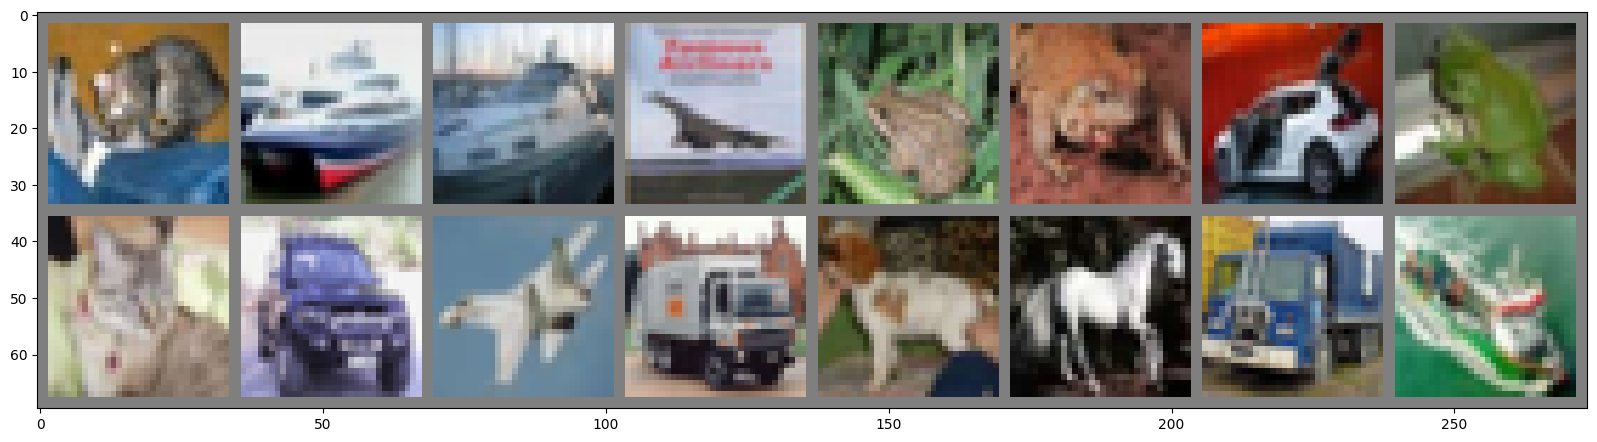

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship
Predicted:    cat  ship  ship plane  frog  frog   car  frog  bird   car  deer truck  frog horse truck plane


In [12]:
def imshow(img, transpose = False):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

plt.figure(figsize=(20, 40))
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(16)))

#### **Выбор произвольного примера**

In [13]:
#Индекс нужной картинки
IND = 13

#добавление размерности, формируем батч из одного изображения. Чтобы посмотреть, что изменилось вызовите атрибут shape до и после преобразования
input = images[IND].unsqueeze(0) 
input.requires_grad = True

In [14]:
# Получение прогноза
_, predicted = torch.max(net(images[IND]), 1)
print('Прогноз для примера из выборки:', classes[predicted])

Прогноз для примера из выборки: horse


### **Раздел 4. Получение атрибуций (карт активаций)** 
Объявляем  функцию для получения атрибуций изображений из [документации captum](https://captum.ai/tutorials/CIFAR_TorchVision_Interpret) и функцию для вычисления индекса Джини. 

In [15]:
def attribute_image_features(algorithm, input, **kwargs):
    
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[IND],
                                              **kwargs
                                             )
    return tensor_attributions
        

Объявляем функцию для вычисления индекса Джини. 
По определению:
$$G(v)=1 - 2*∑_{j}\frac{v_j}{||v||_1}*\frac{d-j+0.5}{d}$$

где  \
$v = [v_1, v_2, v_3, .....,v_d], v_i \leq v_i+1$ — разглаженная карта активации, со значениями, взятыми по модулю и отсортированными в порядке возрастания. \
$$||v||_p = (\sum_jv_j^p)^{\frac{1}{p}}$$

Подробнее про индекс [здесь](https://arxiv.org/pdf/0811.4706v2.pdf). 

In [17]:
def get_gini_index(attribution_map):

  flattened_map = attribution_map.flatten()
  flattened_map_abs_and_sorted = sorted(np.abs(flattened_map)) #Сортируем в порядке возрастания

  d = len(flattened_map_abs_and_sorted) #Длина вектора
  vector_norm = np.linalg.norm(flattened_map_abs_and_sorted, 1)

  s = 0
  for i in range(1, d+1): #Получаем суммы

    coef = (d-i+0.5)/d 
    first = flattened_map_abs_and_sorted[i-1]/vector_norm
    s += coef*first
    
  
  gini_index = 1-2*s

  return gini_index

Вычислим последовательно каждую из карт: 

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


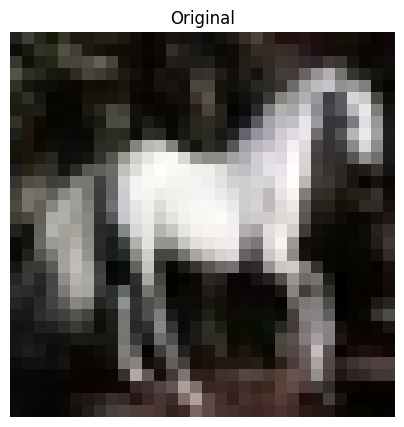

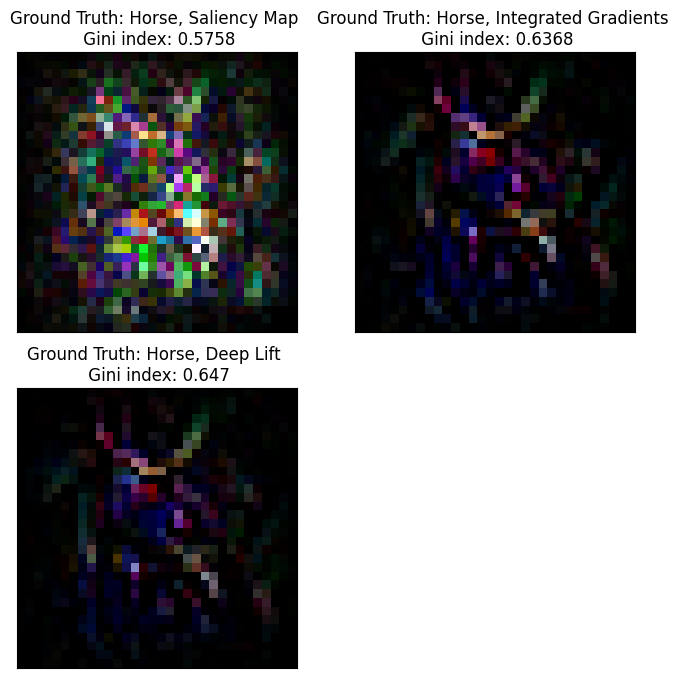

In [18]:

#saliency map
saliency = Saliency(net)
grads = saliency.attribute(input, 
                           target=labels[IND].item())

grads = np.transpose(grads.squeeze().cpu().detach().numpy(), 
                      (1, 2, 0))

#Integrated Gradients
ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, 
                                          input, 
                                          baselines=input * 0, 
                                          return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))


#ВDeep Lift
dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

#Оригинальное изображение 
#(также нормализованное для лучшей читаемости)

orig = np.transpose((images[IND].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

plt.figure(figsize=(5, 5))
plt.imshow(orig)
plt.axis('off')

plt.title('Original')

grads_outputs = [grads, attr_ig, attr_dl]
methods = ['Saliency Map', 'Integrated Gradients', 'Deep Lift']

fig = plt.figure(figsize=(8, 8))

i = 0
for gr, method in zip(grads_outputs, methods):
  

  plt.subplot(2,2,i+1)
  i += 1


  gini_i = np.round(get_gini_index(gr), 5)

  plt.imshow(gr.squeeze()*2, cmap='magma', interpolation='none')
  plt.title(f"Ground Truth: Horse, {method} \n Gini index: {round(gini_i, 4)}")



  plt.xticks([])
  plt.yticks([])

fig.show()
fig.savefig('GINI_Cifar')

И для наглдности наложим карты на оригинальное изображение (см. туториал в документации captum).

Original Image


<Figure size 1200x1200 with 0 Axes>

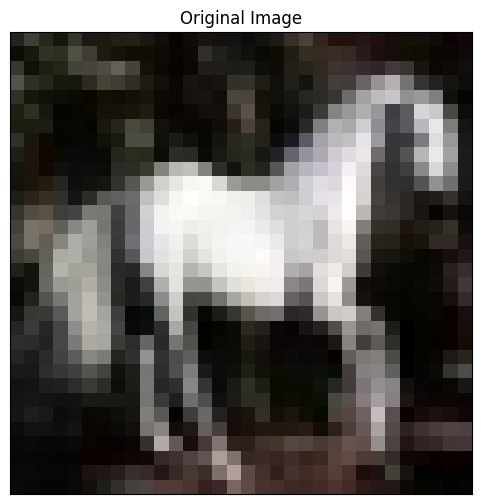

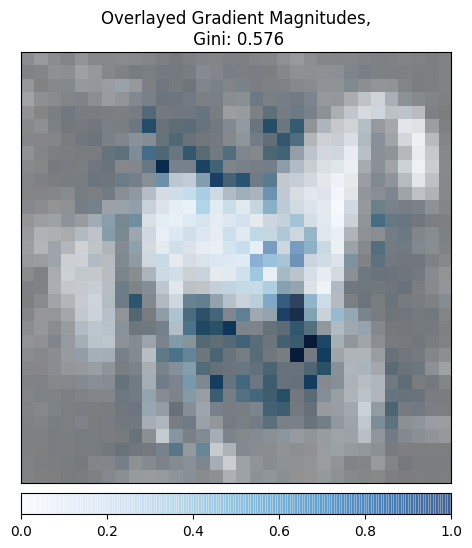

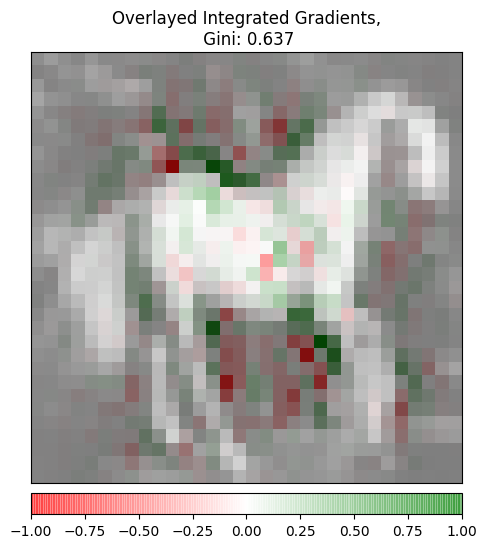

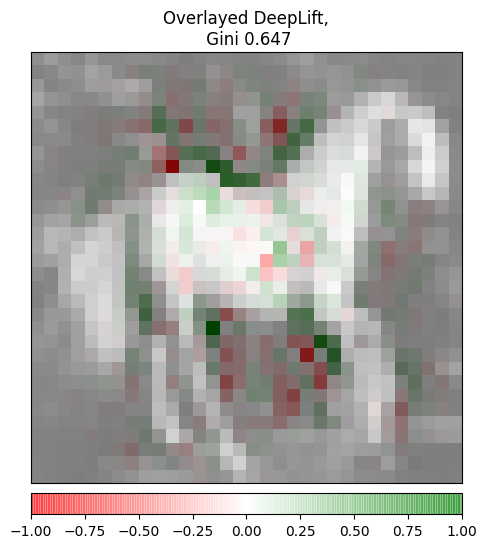

In [19]:
print('Original Image')

plt.figure(figsize=(12,12))
original_image = np.transpose((images[IND].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value", show_colorbar=True, 
                             title=f"Overlayed Gradient Magnitudes,\n Gini: {round(get_gini_index(grads), 3)}")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all", show_colorbar=True, 
                             title=f"Overlayed Integrated Gradients,\n Gini: {round(get_gini_index(attr_ig), 3)}")


_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title=f"Overlayed DeepLift,\n Gini {round(get_gini_index(attr_dl), 3)}")



Для дальнейшего анализа вычислим индекс Джини для каждого наблюдения каждого из классов из тестовой выборки. 

In [20]:
def get_class_gini(dataloader, test_classes, model, method):

  """Функция для подсчета индекса Джини каждым из методов для объектов разных классов
  
  dataloader: test dataloader;
  test classes: имена классов в тестовом наборе данных
  model: модель
  method: название метода — Saliency, DeepLift или IntegratedGradients"""
  classes_gini = {classname: [] for classname in test_classes}

  with torch.no_grad():
    for data in dataloader:
        images, labels = data
        for image, label in zip(images, labels):

          image = image.unsqueeze(0)
          image.requires_grad = True

          if method == 'Saliency':
            
            saliency = Saliency(model)
            result = saliency.attribute(image, target=label)
            result = np.transpose(result.squeeze().cpu().detach().numpy(), (1, 2, 0))
            

          if method == 'DeepLift':
            
            dl = DeepLift(model)
            result = attribute_image_features(dl, image, baselines=image * 0)
            result = np.transpose(result.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
            
          if method == 'IntegratedGradients':
            
            ig = IntegratedGradients(model)
            result = attribute_image_features(ig, image, baselines=image * 0, return_convergence_delta=False)
            
            result = np.transpose(result.squeeze().cpu().detach().numpy(), (1, 2, 0))
            
            
          index_ = gini_index(result)
          classes_gini[classes[label]].append(index_)


    
    return classes_gini

  

Получим индекс Джини для каждого прогноза. Для удобства они преобразованы в csv файлы (см. папку data), но вы можете сохранить и вычислить свои собственные. 

In [ ]:
saliency_ginis = get_class_gini(testloader, classes, net, 'Saliency')

In [ ]:
dl_ginis = get_class_gini(testloader, classes, net, 'DeepLift')

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [ ]:
ig_ginis = get_class_gini(testloader, classes, net, 'IntegratedGradients')

Рассчитаем точность. 

In [ ]:
#Рассчет точности для каждого класса 
accuracy_dict = {classname: 0 for classname in classes}

# количество верных и не верных прогнозов
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Получение прогнозов
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)

        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# вычисление доли правильных ответов на каждый класс
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    accuracy_dict[classname] = accuracy
   

In [ ]:
#Проверим, что все корректно и вычислим некоторые статистики

acc_data = pd.DataFrame(accuracy_dict.items(), columns=['class', 'accuracy'])
acc_data.head(3)

,class,accuracy
0,plane,63.5
1,car,66.1
2,bird,36.2


In [ ]:
acc_data['median_saliency_gini'] = [np.median(np.array(x)) for x in ig_ginis.values()]
acc_data['median_ig_gini'] = [np.median(np.array(x)) for x in saliency_ginis.values()]
acc_data['median_dl_gini'] = [np.median(np.array(x)) for x in dl_ginis.values()]

In [ ]:
acc_data.to_csv('cifar10ginis_data.csv', sep='\t')

Анализ полученных результатов и продолжение данной работы см. в ноутбуке Gini Analysis. 